In [120]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_roc_curve, plot_precision_recall_curve 
import pandas as pd
import numpy as np 
from functools import partial
import plotly

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
warnings.filterwarnings("ignore")


In [93]:
features_df = pd.read_csv("bitcoin_train.csv")
features_df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Daily_Change,Daily_Change_Ind,MACD,...,Open_Gold,Daily_Change_Gold,Daily_Change_Perc_Gold,Increased_Gold,Close/Last_SP500,Open_SP500,Daily_Change_SP500,Daily_Change_Perc_SP500,Increased_SP500,label
0,708,2017-08-28,4384.450195,4403.930176,4224.640137,4382.660156,1959330048,-0.219727,0.0,318.734756,...,1297.6,17.7,0.013641,1,2444.24,2447.35,-3.11,-0.001271,0,1.0
1,563,2017-01-31,920.958984,972.018982,920.958984,970.403015,164582000,50.020996,1.0,12.846431,...,1197.7,13.7,0.011439,1,2278.87,2274.02,4.85,0.002133,1,1.0
2,1390,2020-05-14,9271.329102,9793.268555,9255.035156,9733.721680,56426907637,463.734375,1.0,491.284984,...,1723.1,17.8,0.010330,1,2852.50,2794.54,57.96,0.020740,1,0.0
3,19,2014-11-10,362.265015,374.816010,357.561005,366.924011,30450100,3.660003,1.0,-5.684871,...,1176.8,-17.0,-0.014446,0,2038.26,2032.01,6.25,0.003076,1,1.0
4,944,2018-08-06,7062.939941,7166.549805,6890.540039,6951.799805,3925900000,-116.680175,0.0,55.940525,...,1214.4,-5.8,-0.004776,0,2850.40,2840.29,10.11,0.003559,1,0.0


In [94]:
features_df.columns

feature_lst = ['Daily_Change', 'Daily_Change_Ind', 'MACD', 'PROC_3', 'PROC_5','PROC_10', 'wpr',\
                'sto_os', 'goog_trend_score', 'count', 'compound', 'retweets_count', 'likes_count', 'replies_count',\
                'compound_weighted_replies', 'compound_weighted_likes','compound_weighted_retweets',\
                'Daily_Change_Perc', 'Daily_Change_Gold', 'Daily_Change_Perc_Gold', 'Increased_Gold', \
                'Daily_Change_SP500', 'Daily_Change_Perc_SP500', 'Increased_SP500']

outcome = features_df.columns[-1]

print(feature_lst)
print(outcome)

['Daily_Change', 'Daily_Change_Ind', 'MACD', 'PROC_3', 'PROC_5', 'PROC_10', 'wpr', 'sto_os', 'goog_trend_score', 'count', 'compound', 'retweets_count', 'likes_count', 'replies_count', 'compound_weighted_replies', 'compound_weighted_likes', 'compound_weighted_retweets', 'Daily_Change_Perc', 'Daily_Change_Gold', 'Daily_Change_Perc_Gold', 'Increased_Gold', 'Daily_Change_SP500', 'Daily_Change_Perc_SP500', 'Increased_SP500']
label


In [95]:
X = features_df[feature_lst]
y = features_df[outcome]
print(X.shape, y.shape)

(1250, 24) (1250,)


In [96]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 1234)

-----------------------------------------------
Trying what Ana gave me for hyperparameter tuning (OPTUNA):

In [114]:
# USING OPTUNA TO CHOOSE BEST HYPERPARAMETERS
# this function came from Ana

#https://towardsdatascience.com/state-of-the-art-machine-learning-hyperparameter-optimization-with-optuna-a315d8564de1
def objective(trial:Trial, train = None, labels = None, val = None, val_labels = None, val_rets = None):
    ada_m_depth = trial.suggest_int("max_depth", 1, 5, step = 1)
    ada_n_estimators = trial.suggest_int("n_estimators", 50, 1000, step = 50)
    ada_learning_rate = trial.suggest_float("learning_rate", 0.001, 1.0, step = .009)

    base_estimator = DecisionTreeClassifier(max_depth = ada_m_depth, random_state = 1234)
    ada_clf = AdaBoostClassifier(base_estimator, 
                                n_estimators = ada_n_estimators,
                                learning_rate = ada_learning_rate,
                                algorithm = "SAMME.R")
    ada_clf.fit(X_train, y_train)
    accuracy = ada_clf.score(X_valid, y_valid)

    return accuracy

In [115]:
study = optuna.create_study(direction = "maximize")


In [142]:
import plotly.express as px
fig = px.bar(x=["a", "b", "c"], y=[1, 3, 2])
fig.show()

In [116]:
# Line 3 and 6 is  from ANa

#%%time 

# Line 6 is copy/pasted from Ana, have not updated to our data/var names at this point
# study.optimize(partial(objective,train=train_1,labels=y_1,val=valid,val_labels=y_valid,val_rets=valid_stock_returns), n_trials=20,n_jobs=-1)

# the below code doesn't work at this point but is me trying out oputna.
study.optimize(objective, n_trials = 20, n_jobs = -1)


trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

    # create function to pass in objective?

Best Score:  0.5431309904153354
Best Params: 
  max_depth: 4
  n_estimators: 50
  learning_rate: 0.3109313893636552


In [ ]:
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly

from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
# https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html?highlight=visualization
# plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)

end of what Ana suggested

-----------------------------------------------------------------------

run a regular decision tree model with different tree depth, 
use as comparison to show that adaboost is better

In [100]:
# Figure out what the tree depth should be (maximum score)
results_dict = {}
cx_validation = KFold(n_splits = 10, shuffle = True, random_state = 1)
for depth in range(1, 11):
    base_estimator = DecisionTreeClassifier(max_depth = depth, random_state = 1234)
    if base_estimator.fit(X_train,y_train).tree_.max_depth < depth:
        break
    accuracy_score = np.mean(cross_val_score(base_estimator, X, y, cv = cx_validation, scoring = 'accuracy', n_jobs = 1))
    print("Depth:", depth, ", Score:", accuracy_score)

    results_dict[depth] = accuracy_score

max_val = -1
max_depth_val = None
for key, val in results_dict.items():
    if val > max_val:
        max_val = val
        max_depth_val = key

print("Max depth should be:", max_depth_val)

    # https://educationalresearchtechniques.com/2019/01/02/adaboost-classification-in-python/
    # https://towardsdatascience.com/boosting-and-adaboost-clearly-explained-856e21152d3e
    # https://python-bloggers.com/2019/01/adaboost-classification-in-python/ # this one for 
    

Depth: 1 , Score: 0.5232000000000001
Depth: 2 , Score: 0.5119999999999999
Depth: 3 , Score: 0.5176000000000001
Depth: 4 , Score: 0.5216
Depth: 5 , Score: 0.5192
Depth: 6 , Score: 0.5199999999999999
Depth: 7 , Score: 0.5008000000000001
Depth: 8 , Score: 0.5040000000000001
Depth: 9 , Score: 0.5104000000000001
Depth: 10 , Score: 0.4952
Max depth should be: 1


Straight run of the model with default chosen n_estimators and learning_rate

In [101]:
# Create adaboost classifer object
base_estimator = DecisionTreeClassifier(max_depth = 1, random_state = 1234)

adaboost = AdaBoostClassifier(base_estimator = base_estimator, random_state = 1234)

# Train Adaboost Classifer
adaboost.fit(X_train, y_train)

# Predict the response for valid dataset
y_hat = adaboost.predict(X_valid)

In [102]:
# Model Accuracy with chosen decision tree depth and randomly chosen hyperparameters
accuracy_score = metrics.accuracy_score(y_valid, y_hat)
mse = metrics.mean_squared_error(y_valid, y_hat)
confusion = metrics.confusion_matrix(y_valid, y_hat) 

print("Accuracy:", accuracy_score)
print("MSE:", mse)
print("CONFUSION:", confusion)

## Consider changing to this wiht the cross val score even for default/trying things out.
# Probably leave at decision stump instead of max depth thing
# https://medium.com/@chaudhurysrijani/tuning-of-adaboost-with-computational-complexity-8727d01a9d20

Accuracy: 0.48242811501597443
MSE: 0.5175718849840255
CONFUSION: [[ 51  81]
 [ 81 100]]


In [103]:
feature_import = adaboost.feature_importances_
for i in range(len(feature_lst)):
    print(f"{feature_lst[i]}: {feature_import[i]}")

Daily_Change: 0.06
Daily_Change_Ind: 0.0
MACD: 0.04
PROC_3: 0.06
PROC_5: 0.06
PROC_10: 0.12
wpr: 0.02
sto_os: 0.02
goog_trend_score: 0.02
count: 0.0
compound: 0.08
retweets_count: 0.0
likes_count: 0.02
replies_count: 0.0
compound_weighted_replies: 0.12
compound_weighted_likes: 0.1
compound_weighted_retweets: 0.04
Daily_Change_Perc: 0.04
Daily_Change_Gold: 0.02
Daily_Change_Perc_Gold: 0.04
Increased_Gold: 0.0
Daily_Change_SP500: 0.06
Daily_Change_Perc_SP500: 0.08
Increased_SP500: 0.0


hyper parametertuning (number estimators and learning rate)


tuning n_estimators and learning_Rate

In [104]:
# https://machinelearningmastery.com/adaboost-ensemble-in-python/

# alternative way to check n_estiamtors and learning_Rate
model = AdaBoostClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500, 1000]
grid['learning_rate'] = [0.001, 0.01, 0.1, 1.0]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

# define the grid search procedure
grid_search = GridSearchCV(estimator = model, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy')

# execute the grid search
grid_result = grid_search.fit(X_train, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.533940 using {'learning_rate': 0.001, 'n_estimators': 1000}
0.522192 (0.032021) with: {'learning_rate': 0.001, 'n_estimators': 10}
0.519683 (0.033368) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.521463 (0.034043) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.531450 (0.023879) with: {'learning_rate': 0.001, 'n_estimators': 500}
0.533940 (0.030427) with: {'learning_rate': 0.001, 'n_estimators': 1000}
0.521467 (0.033088) with: {'learning_rate': 0.01, 'n_estimators': 10}
0.530740 (0.024479) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.532170 (0.028585) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.520838 (0.043960) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.515149 (0.043700) with: {'learning_rate': 0.01, 'n_estimators': 1000}
0.532868 (0.024182) with: {'learning_rate': 0.1, 'n_estimators': 10}
0.524056 (0.042356) with: {'learning_rate': 0.1, 'n_estimators': 50}
0.513368 (0.045079) with: {'learning_rate': 0.1, 'n_estimators': 100}
0.513033 (0

Rerun adaboost with chosen hyperparameters

In [109]:
base_estimator = DecisionTreeClassifier(max_depth = 1, random_state = 1234)

chosen_learning_rate = list(grid_result.best_params_.values())[0]
chosen_n = list(grid_result.best_params_.values())[1]

print("chosen_n:", chosen_n)
print("chosen_learing_rate:", chosen_learning_rate)

adaboost = AdaBoostClassifier(base_estimator = base_estimator, n_estimators = chosen_n,
                              learning_rate = chosen_learning_rate, random_state = 1234)

# Train Adaboost Classifer
adaboost.fit(X_train, y_train)

# Predict the response for valid dataset
y_hat = adaboost.predict(X_valid)

chosen_n: 1000
chosen_learing_rate: 0.001


In [110]:
# Model Accuracy with chosen decision tree depth and chosen hyperparameters
accuracy_score = metrics.accuracy_score(y_valid, y_hat)
mse = metrics.mean_squared_error(y_valid, y_hat)
confusion = metrics.confusion_matrix(y_valid, y_hat) 

print("Accuracy:", accuracy_score)
print("MSE:", mse)
print("CONFUSION:", confusion)

Accuracy: 0.5782747603833865
MSE: 0.4217252396166134
CONFUSION: [[ 21 111]
 [ 21 160]]


[[ 21 111]
 [ 21 160]]


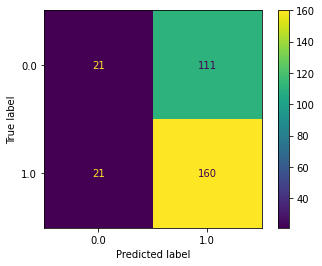

In [113]:
plot_confusion_matrix(adaboost, X_valid, y_valid)
print(metrics.confusion_matrix(y_valid, y_hat))

In [71]:
feature_import = adaboost.feature_importances_
for i in range(len(feature_lst)):
    print(f"{feature_lst[i]}: {feature_import[i]}")

Daily_Change: 0.08
Daily_Change_Ind: 0.0
MACD: 0.0
PROC_3: 0.24
PROC_5: 0.26
PROC_10: 0.0
wpr: 0.14
sto_os: 0.08
goog_trend_score: 0.0
count: 0.0
compound: 0.0
retweets_count: 0.0
likes_count: 0.0
replies_count: 0.0
compound_weighted_replies: 0.0
compound_weighted_likes: 0.0
compound_weighted_retweets: 0.0
Daily_Change_Perc: 0.18
Daily_Change_Gold: 0.0
Daily_Change_Perc_Gold: 0.02
Increased_Gold: 0.0
Daily_Change_SP500: 0.0
Daily_Change_Perc_SP500: 0.0
Increased_SP500: 0.0


In [21]:
# now try adjusting depth? This needs to be done simultaneously if at all...might be where optuna is helpful
score = []
for depth in [1,2,3] : 
    base_estimator = DecisionTreeClassifier(max_depth = depth, random_state = 1234)
    adaboost = AdaBoostClassifier(base_estimator = base_estimator, n_estimators = chosen_n,
                              learning_rate = chosen_learning_rate, random_state = 1234)
    scores_ada = cross_val_score(adaboost, X_train, y_train)
    score.append(scores_ada.mean())

In [20]:
print("score", score)

score [0.6581400729489901, 0.6720017420654364, 0.6113560890630954]


In [ ]:
''' other links
https://inria.github.io/scikit-learn-mooc/python_scripts/ensemble_adaboost.html
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
 https://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html
 https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
 
 https://towardsdatascience.com/how-do-you-implement-adaboost-with-python-a76427b0fa7a
 https://towardsdatascience.com/machine-learning-part-17-boosting-algorithms-adaboost-in-python-d00faac6c464
 
 https://machinelearningmastery.com/adaboost-ensemble-in-python/
 https://machinelearningmastery.com/k-fold-cross-validation/

 https://medium.datadriveninvestor.com/understanding-adaboost-and-scikit-learns-algorithm-c8d8af5ace10
 https://blog.paperspace.com/adaboost-optimizer/
 https://www.datacamp.com/tutorial/adaboost-classifier-python
 https://educationalresearchtechniques.com/2019/01/02/adaboost-classification-in-python/

 consider trying standardization https://github.com/mehuls45/Heart-Disease-prediction-using-ML/blob/master/AdaBoost.ipynb

 # no need to normalize/standardize in ensemble methods 
 https://towardsdatascience.com/the-ultimate-guide-to-adaboost-random-forests-and-xgboost-7f9327061c4f

 https://github.com/julianikulski/bike-sharing/blob/master/bike_sharing_demand.ipynb

https://www.google.com/search?client=firefox-b-1-d&q=hyperparameter+tuning+adaboost
 https://stackoverflow.com/questions/32210569/using-gridsearchcv-with-adaboost-and-decisiontreeclassifier

# Repeat for Dogecoin


In [144]:
dogecoin = pd.read_csv("dogecoin_train.csv")
dogecoin = dogecoin.rename(columns={'goog_trend': 'goog_trend_score'})

In [146]:
X_dog = dogecoin[feature_lst]
y_dog = dogecoin['label']

In [147]:
X_train, X_valid, y_train, y_valid = train_test_split(X_dog, y_dog, random_state = 1234)

In [148]:
def objective(trial:Trial, train = None, labels = None, val = None, val_labels = None, val_rets = None):
    ada_m_depth = trial.suggest_int("max_depth", 1, 5, step = 1)
    ada_n_estimators = trial.suggest_int("n_estimators", 50, 1000, step = 50)
    ada_learning_rate = trial.suggest_float("learning_rate", 0.001, 1.0, step = .009)

    base_estimator = DecisionTreeClassifier(max_depth = ada_m_depth, random_state = 1234)
    ada_clf = AdaBoostClassifier(base_estimator, 
                                n_estimators = ada_n_estimators,
                                learning_rate = ada_learning_rate,
                                algorithm = "SAMME.R")
    ada_clf.fit(X_train, y_train)
    accuracy = ada_clf.score(X_valid, y_valid)

    return accuracy

In [149]:
study = optuna.create_study(direction = "maximize")


In [150]:
study.optimize(objective, n_trials = 20, n_jobs = -1)


trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

Best Score:  0.801829268292683
Best Params: 
  max_depth: 1
  n_estimators: 50
  learning_rate: 0.154


In [151]:
# Figure out what the tree depth should be (maximum score)
results_dict = {}
cx_validation = KFold(n_splits = 10, shuffle = True, random_state = 1)
for depth in range(1, 11):
    base_estimator = DecisionTreeClassifier(max_depth = depth, random_state = 1234)
    if base_estimator.fit(X_train,y_train).tree_.max_depth < depth:
        break
    accuracy_score = np.mean(cross_val_score(base_estimator, X, y, cv = cx_validation, scoring = 'accuracy', n_jobs = 1))
    print("Depth:", depth, ", Score:", accuracy_score)

    results_dict[depth] = accuracy_score

max_val = -1
max_depth_val = None
for key, val in results_dict.items():
    if val > max_val:
        max_val = val
        max_depth_val = key

print("Max depth should be:", max_depth_val)

Depth: 1 , Score: 0.5232000000000001
Depth: 2 , Score: 0.5119999999999999
Depth: 3 , Score: 0.5176000000000001
Depth: 4 , Score: 0.5216
Depth: 5 , Score: 0.5192
Depth: 6 , Score: 0.5199999999999999
Depth: 7 , Score: 0.5008000000000001
Depth: 8 , Score: 0.5040000000000001
Depth: 9 , Score: 0.5104000000000001
Depth: 10 , Score: 0.4952
Max depth should be: 1


In [152]:
# Create adaboost classifer object
base_estimator = DecisionTreeClassifier(max_depth = 1, random_state = 1234)

adaboost = AdaBoostClassifier(base_estimator = base_estimator, random_state = 1234)

# Train Adaboost Classifer
adaboost.fit(X_train, y_train)

# Predict the response for valid dataset
y_hat = adaboost.predict(X_valid)

In [153]:
# Model Accuracy with chosen decision tree depth and randomly chosen hyperparameters
accuracy_score = metrics.accuracy_score(y_valid, y_hat)
mse = metrics.mean_squared_error(y_valid, y_hat)
confusion = metrics.confusion_matrix(y_valid, y_hat) 

print("Accuracy:", accuracy_score)
print("MSE:", mse)
print("CONFUSION:", confusion)


Accuracy: 0.7835365853658537
MSE: 0.21646341463414634
CONFUSION: [[239  22]
 [ 49  18]]


In [154]:
feature_import = adaboost.feature_importances_
for i in range(len(feature_lst)):
    print(f"{feature_lst[i]}: {feature_import[i]}")

Daily_Change: 0.1
Daily_Change_Ind: 0.0
MACD: 0.12
PROC_3: 0.04
PROC_5: 0.04
PROC_10: 0.04
wpr: 0.08
sto_os: 0.02
goog_trend_score: 0.12
count: 0.0
compound: 0.02
retweets_count: 0.0
likes_count: 0.04
replies_count: 0.02
compound_weighted_replies: 0.04
compound_weighted_likes: 0.0
compound_weighted_retweets: 0.02
Daily_Change_Perc: 0.02
Daily_Change_Gold: 0.1
Daily_Change_Perc_Gold: 0.1
Increased_Gold: 0.0
Daily_Change_SP500: 0.08
Daily_Change_Perc_SP500: 0.0
Increased_SP500: 0.0


hyper parametertuning (number estimators and learning rate)


In [155]:
model = AdaBoostClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500, 1000]
grid['learning_rate'] = [0.001, 0.01, 0.1, 1.0]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

# define the grid search procedure
grid_search = GridSearchCV(estimator = model, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy')

# execute the grid search
grid_result = grid_search.fit(X_train, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.805308 using {'learning_rate': 0.001, 'n_estimators': 10}
0.805308 (0.002443) with: {'learning_rate': 0.001, 'n_estimators': 10}
0.805308 (0.002443) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.805308 (0.002443) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.805308 (0.002443) with: {'learning_rate': 0.001, 'n_estimators': 500}
0.805308 (0.002443) with: {'learning_rate': 0.001, 'n_estimators': 1000}
0.805308 (0.002443) with: {'learning_rate': 0.01, 'n_estimators': 10}
0.805308 (0.002443) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.805308 (0.002443) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.802584 (0.008477) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.803278 (0.019011) with: {'learning_rate': 0.01, 'n_estimators': 1000}
0.805308 (0.002443) with: {'learning_rate': 0.1, 'n_estimators': 10}
0.802244 (0.008115) with: {'learning_rate': 0.1, 'n_estimators': 50}
0.802261 (0.018886) with: {'learning_rate': 0.1, 'n_estimators': 100}
0.788332 (0.0

Rerun adaboost with chosen hyperparameters

In [156]:
base_estimator = DecisionTreeClassifier(max_depth = 1, random_state = 1234)

chosen_learning_rate = list(grid_result.best_params_.values())[0]
chosen_n = list(grid_result.best_params_.values())[1]

print("chosen_n:", chosen_n)
print("chosen_learing_rate:", chosen_learning_rate)

adaboost = AdaBoostClassifier(base_estimator = base_estimator, n_estimators = chosen_n,
                              learning_rate = chosen_learning_rate, random_state = 1234)

# Train Adaboost Classifer
adaboost.fit(X_train, y_train)

# Predict the response for valid dataset
y_hat = adaboost.predict(X_valid)

chosen_n: 10
chosen_learing_rate: 0.001


In [157]:
accuracy_score = metrics.accuracy_score(y_valid, y_hat)
mse = metrics.mean_squared_error(y_valid, y_hat)
confusion = metrics.confusion_matrix(y_valid, y_hat) 

print("Accuracy:", accuracy_score)
print("MSE:", mse)
print("CONFUSION:", confusion)

Accuracy: 0.7957317073170732
MSE: 0.20426829268292682
CONFUSION: [[261   0]
 [ 67   0]]


[[261   0]
 [ 67   0]]


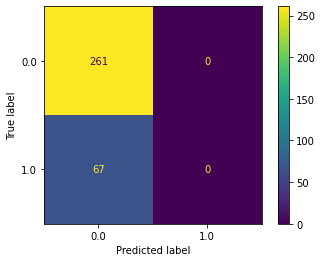

In [158]:
plot_confusion_matrix(adaboost, X_valid, y_valid)
print(metrics.confusion_matrix(y_valid, y_hat))

In [159]:
feature_import = adaboost.feature_importances_
for i in range(len(feature_lst)):
    print(f"{feature_lst[i]}: {feature_import[i]}")

Daily_Change: 0.0
Daily_Change_Ind: 0.0
MACD: 1.0
PROC_3: 0.0
PROC_5: 0.0
PROC_10: 0.0
wpr: 0.0
sto_os: 0.0
goog_trend_score: 0.0
count: 0.0
compound: 0.0
retweets_count: 0.0
likes_count: 0.0
replies_count: 0.0
compound_weighted_replies: 0.0
compound_weighted_likes: 0.0
compound_weighted_retweets: 0.0
Daily_Change_Perc: 0.0
Daily_Change_Gold: 0.0
Daily_Change_Perc_Gold: 0.0
Increased_Gold: 0.0
Daily_Change_SP500: 0.0
Daily_Change_Perc_SP500: 0.0
Increased_SP500: 0.0


--------------------------------------------------------------------
# MISC OTHER CODE NOT USING

-------------------------------------------------------------
We will evaluate the model using repeated stratified k-fold cross-validation, with three repeats and 10 folds. We will report the mean and standard deviation of the accuracy of the model across all repeats and folds.

https://machinelearningmastery.com/adaboost-ensemble-in-python/

In [45]:
model = AdaBoostClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1234)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.635 (0.053)


This achieved 63.5% accuracy with default hyperparameters. Now make predictions on new data

In [47]:
model = AdaBoostClassifier()
# fit the model on the whole dataset
model.fit(X_train, y_train)
# make a single prediction
y_hat = model.predict(X_valid)

accuracy_score = metrics.accuracy_score(y_valid, y_hat)
mse = metrics.mean_squared_error(y_valid, y_hat)
confusion = metrics.confusion_matrix(y_valid, y_hat) 

print("Accuracy:", accuracy_score)
print("MSE:", mse)
print("CONFUSION:", confusion)

Accuracy: 0.7070063694267515
MSE: 0.2929936305732484
CONFUSION: [[ 91  45]
 [ 47 131]]


In [53]:
base_estimator = DecisionTreeClassifier(max_depth=3, random_state=1234)
adaboost = AdaBoostClassifier(base_estimator=base_estimator,
                              n_estimators=3, algorithm="SAMME",
                              random_state=0)
adaboost.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1234),
                   n_estimators=3, random_state=0)

In [58]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import DecisionBoundaryDisplay


ImportError: cannot import name 'DecisionBoundaryDisplay' from 'sklearn.inspection' (/home/ksarussi/.local/lib/python3.8/site-packages/sklearn/inspection/__init__.py)

In [56]:
for boosting_round, tree in enumerate(adaboost.estimators_):
    plt.figure()
    # we convert `data` into a NumPy array to avoid a warning raised in scikit-learn
    DecisionBoundaryDisplay.from_estimator(
        tree, X_train.to_numpy(), response_method="predict", cmap="RdBu", alpha=0.5
    )
    sns.scatterplot(x=culmen_columns[0], y=culmen_columns[1],
                    hue=target_column, data=penguins,
                    palette=palette)
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    _ = plt.title(f"Decision tree trained at round {boosting_round}")

NameError: name 'DecisionBoundaryDisplay' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
# hyper parametertuning (number estimators and learning rate)
# ada = AdaBoostClassifier()
# search_grid = {'n_estimators':[500,1000,2000], 'learning_rate':[.001,0.01,.1]}
# search = GridSearchCV(estimator = ada, param_grid = search_grid, scoring = 'accuracy', n_jobs = 1, cv = cx_validation)

#https://python-bloggers.com/2019/01/adaboost-classification-in-python/

# search.fit(X,y)
# search.best_params_
# print(search.best_params_)
# search.best_score_
# print(search.best_score_)
#Out[34]: 0.7425149700598802



# https://python-bloggers.com/2019/01/adaboost-classification-in-python/

# score = np.mean(cross_val_score(ada, X, y, scoring='accuracy', cv = cx_validation, n_jobs = 1))
# score


#https://python-bloggers.com/2019/01/adaboost-classification-in-python/

# AdaBoostClassifier.get_params().keys()